I couldn't find a notebook using the new mmdet version 3.0.0, so I made one myself. Please let me know if there are any mistakes!

training notebook is [here](https://www.kaggle.com/code/andtaichi/hubmap-mmdet-ver3-0-0-training).

In [1]:
!pip install -qqq /kaggle/input/mmdet3-wheels-ando/addict-2.4.0-py3-none-any.whl
!pip install -qqq /kaggle/input/mmdet3-wheels-ando/mmengine-0.7.3-py3-none-any.whl
!pip install -qqq /kaggle/input/mmdet3-wheels-ando/mmcv-2.0.0-cp310-cp310-linux_x86_64.whl
!pip install -qqq /kaggle/input/pycocotools-206/wheels/pycocotools-2.0.6-cp310-cp310-linux_x86_64.whl
!pip install -qqq /kaggle/input/mmdet3-wheels-ando/terminaltables-3.1.10-py2.py3-none-any.whl
!pip install -qqq /kaggle/input/mmdet3-wheels-ando/mmdet-3.0.0-py3-none-any.whl

In [2]:
import base64
import numpy as np
from pycocotools import _mask as coco_mask
import typing as t
import zlib


def encode_binary_mask(mask: np.ndarray) -> t.Text:
  """Converts a binary mask into OID challenge encoding ascii text."""

  # check input mask --
  if mask.dtype != np.bool:
    raise ValueError(
        "encode_binary_mask expects a binary mask, received dtype == %s" %
        mask.dtype)

  mask = np.squeeze(mask)
  if len(mask.shape) != 2:
    raise ValueError(
        "encode_binary_mask expects a 2d mask, received shape == %s" %
        mask.shape)

  # convert input mask to expected COCO API input --
  mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
  mask_to_encode = mask_to_encode.astype(np.uint8)
  mask_to_encode = np.asfortranarray(mask_to_encode)

  # RLE encode mask --
  encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

  # compress and base64 encoding --
  binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
  base64_str = base64.b64encode(binary_str)
  return base64_str

In [3]:
import numpy as np
import pandas as pd
import os

In [4]:
import mmdet, mmcv, mmengine
from mmengine.config import Config
from mmengine.runner import Runner
from mmdet.utils import register_all_modules
from mmdet.apis import init_detector, inference_detector
from mmengine.visualization import Visualizer


print(mmdet.__version__)
print(mmcv.__version__)
print(mmengine.__version__)

3.0.0
2.0.0
0.7.3


In [5]:
%mkdir work_dir_test

cfg = Config.fromfile("/kaggle/input/mmdet-outputs/work_dir/custom_config.py")
cfg.work_dir = "/kaggle/working/work_dir_test"
vis_backends = [dict(type='LocalVisBackend')]
cfg.visualizer = dict(type='DetLocalVisualizer', vis_backends=vis_backends, name='visualizer')
runner = Runner.from_cfg(cfg)

08/01 07:08:28 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06) [GCC 11.3.0]
    CUDA available: True
    numpy_random_seed: 1879079399
    GPU 0: Tesla P100-PCIE-16GB
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: gcc (Ubuntu 11.3.0-1ubuntu1~22.04) 11.3.0
    PyTorch: 2.0.0
    PyTorch compiling details: PyTorch built with:
  - GCC 11.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-genc

In [6]:
path_list = ["/kaggle/input/hubmap-hacking-the-human-vasculature/test/"+i for i in os.listdir("/kaggle/input/hubmap-hacking-the-human-vasculature/test/")]
path_list

['/kaggle/input/hubmap-hacking-the-human-vasculature/test/72e40acccadf.tif']

In [7]:
img = mmcv.imread("/kaggle/input/hubmap-hacking-the-human-vasculature/test/72e40acccadf.tif")
checkpoint_file = "/kaggle/input/mmdet-outputs/work_dir/best_coco_segm_mAP_epoch_20.pth"

model = init_detector(cfg, checkpoint=checkpoint_file, device="cuda:0")
new_result = inference_detector(model, imgs=path_list)
print(new_result)

Loads checkpoint by local backend from path: /kaggle/input/mmdet-outputs/work_dir/best_coco_segm_mAP_epoch_20.pth
[<DetDataSample(

    META INFORMATION
    ori_shape: (512, 512)
    img_path: '/kaggle/input/hubmap-hacking-the-human-vasculature/test/72e40acccadf.tif'
    img_shape: (1024, 1024)
    img_id: 0
    batch_input_shape: (1024, 1024)
    scale_factor: (2.0, 2.0)
    pad_shape: (1024, 1024)

    DATA FIELDS
    ignored_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
        ) at 0x7ff2bdc95870>
    pred_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            bboxes: tensor([[3.0926e+02, 4.7701e+02, 3.7509e+02, 5.1035e+02],
                        [2.4591e+02, 4.4255e+02, 3.0320e+02, 4.8580e+02],
                        [3.2427e+02, 2.4165e+02, 4.2472e+02, 2.8917e+02],
                        [4.7377e+02, 2.1788e+02, 5.0946e+02, 2.6378e+02],
                        [4.3223e+02,

/opt/conda/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:757: UserWarning: Warning: The bbox is out of bounds, the drawn bbox may not be in the image
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:828: UserWarning: Warning: The polygon is out of bounds, the drawn polygon may not be in the image
  warnings.warn(


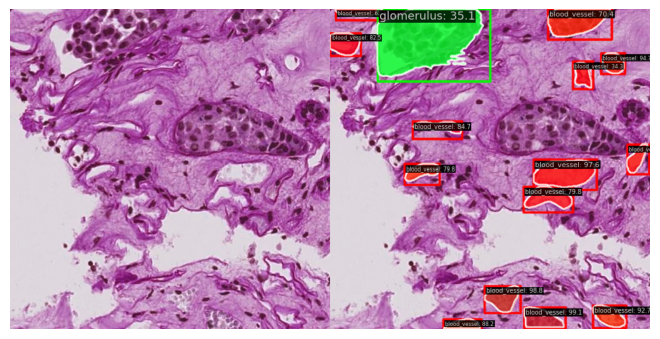

In [8]:
visualizer_now = Visualizer.get_current_instance()

visualizer_now.dataset_meta = model.dataset_meta
visualizer_now.set_image(img)
visualizer_now.add_datasample(
    'new_result',
    img,
    data_sample=new_result[0],
    draw_gt=True,
    draw_pred=True,
    wait_time=0,
)
visualizer_now.show()

In [9]:
import cv2
ids = []
heights = []
widths = []
prediction_string = []

for res in new_result:
    pr_i = res.pred_instances
    id = res.img_path.split("/")[-1][:-4]
    shape = new_result[0].img_shape
    height = shape[0]
    width = shape[1]

    scores = pr_i.scores.cpu().numpy()
    masks = pr_i.masks.cpu().numpy()
    # print(id, shape, height, width, scores, masks.shape)

    pred_strings = []
    for score, mask in zip(scores, masks):
        mask = mask.astype(np.uint8)
#         kernel = np.ones(shape=(3, 3), dtype=np.uint8)
#         binary_mask = cv2.dilate(mask, kernel, 3)    
        binary_mask = mask.astype(bool)    
        pred_strings.append(" ".join(["0", str(score), encode_binary_mask(binary_mask).decode()]))
    ids.append(id)
    heights.append(512)
    widths.append(512)
    prediction_string.append(" ".join(pred_strings))

sub = pd.DataFrame({"id": ids, "height": heights, "width": widths, "prediction_string": prediction_string})
sub = sub.set_index("id")
sub.to_csv("submission.csv")

/tmp/ipykernel_22/2951379551.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if mask.dtype != np.bool:


In [10]:
sub

,height,width,prediction_string
id,,,
72e40acccadf,512,512,0 0.9906296 eNrLj8s2sU22N/axdTH2NTAw8Dc0gANDf2...


In [11]:
!cat submission.csv

id,height,width,prediction_string
72e40acccadf,512,512,0 0.9906296 eNrLj8s2sU22N/axdTH2NTAw8Dc0gANDf2xsGAuZxo5hJDIPWRxEGvkZ+4YnhBgBAB8dHpk= 0 0.9883018 eNqLzss2tki3N/Q38jX2N/A38jM0AJL+MGwIgn5QGihrYGgApA0MQBhIglQD1RtCMJj0NwCxQEp8jf3AxgJpIz8gG2iMkY+Jd1hShDEAvawclg== 0 0.97575563 eNqLyAgytUu0N/Iz9DP2MzQw9DP0B7L9DQ0M/A394TSCB1JhAAb+UBoMDP0xWahshB4UjQg+XBjCgJNAQyAOAGKw0/yhzvQ18gc5FuJ0Y5+wjGhDAF4bLX8= 0 0.9726716 eNpLDo81t06yN/U18TX0MwJBfwN/Q39DAyAJYoNoAwMwZegPYQIljP2MfI1BEEQDNRl7RWUaAgDH6hKN 0 0.9472779 eNpLTMo0M0uzt/Qy9jX2NfIz8jfyNfI3MDD0NwSTBgYwEgpgQkDoZ+hvBCTB2vyMfeJyUwwA8LgS7w== 0 0.92656696 eNrLi0sys0i3N/Y18jPyN/I19jP0N/Q3ApMGBiASSIORoQGYYQCjwQwIgLEgWiDajH0NIcYBjYViv4SEZAMAABsa5g== 0 0.881867 eNrLz88yMsyzN/Q3NDDwh5KoLBgPBNBpbCIIYOgPIxHY0N/ID4JDEsJNABThHCk= 0 0.84705913 eNrLDQ0yMsy3N/Qx8Tf0M/Q3NDD0N4CQBiAaHcCkoADIhnCRBRFKMVgIbVDayA/GNTTwh7AQGCjtHZKVZgIAduEjaw== 0 0.82486314 eNqLNUwxiLI39jf0MzSAY38DIIaQEAwjETQcQKUR2v2N/Ix8jfyMgaSxr4m3mWdcXrg5ALT+F4Q= 0 0.79815596 eNqLy8g2NMqyN/U18THyN/Iz